# Docker Image with car price prediction model

* [Docker Tutorials](https://github.com/docker/labs/blob/master/beginner/readme.md)


In [1]:
import os
import sys
import joblib
import requests
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import ensemble

if not os.path.exists("/Users/mayayozhikova/Downloads/docker-tutorial/models") :
    os.mkdir("/Users/mayayozhikova/Downloads/docker-tutorial/models")
MODEL_DIR = "/Users/mayayozhikova/Downloads/docker-tutorial/models"
DATA_DIR = "/Users/mayayozhikova/Downloads/docker-tutorial/data"

In [49]:
df = pd.read_csv(os.path.join(DATA_DIR, r"CarPrice_Assignment.csv"))
numeric_features = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                   'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                   'peakrpm', 'citympg', 'highwaympg']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())])


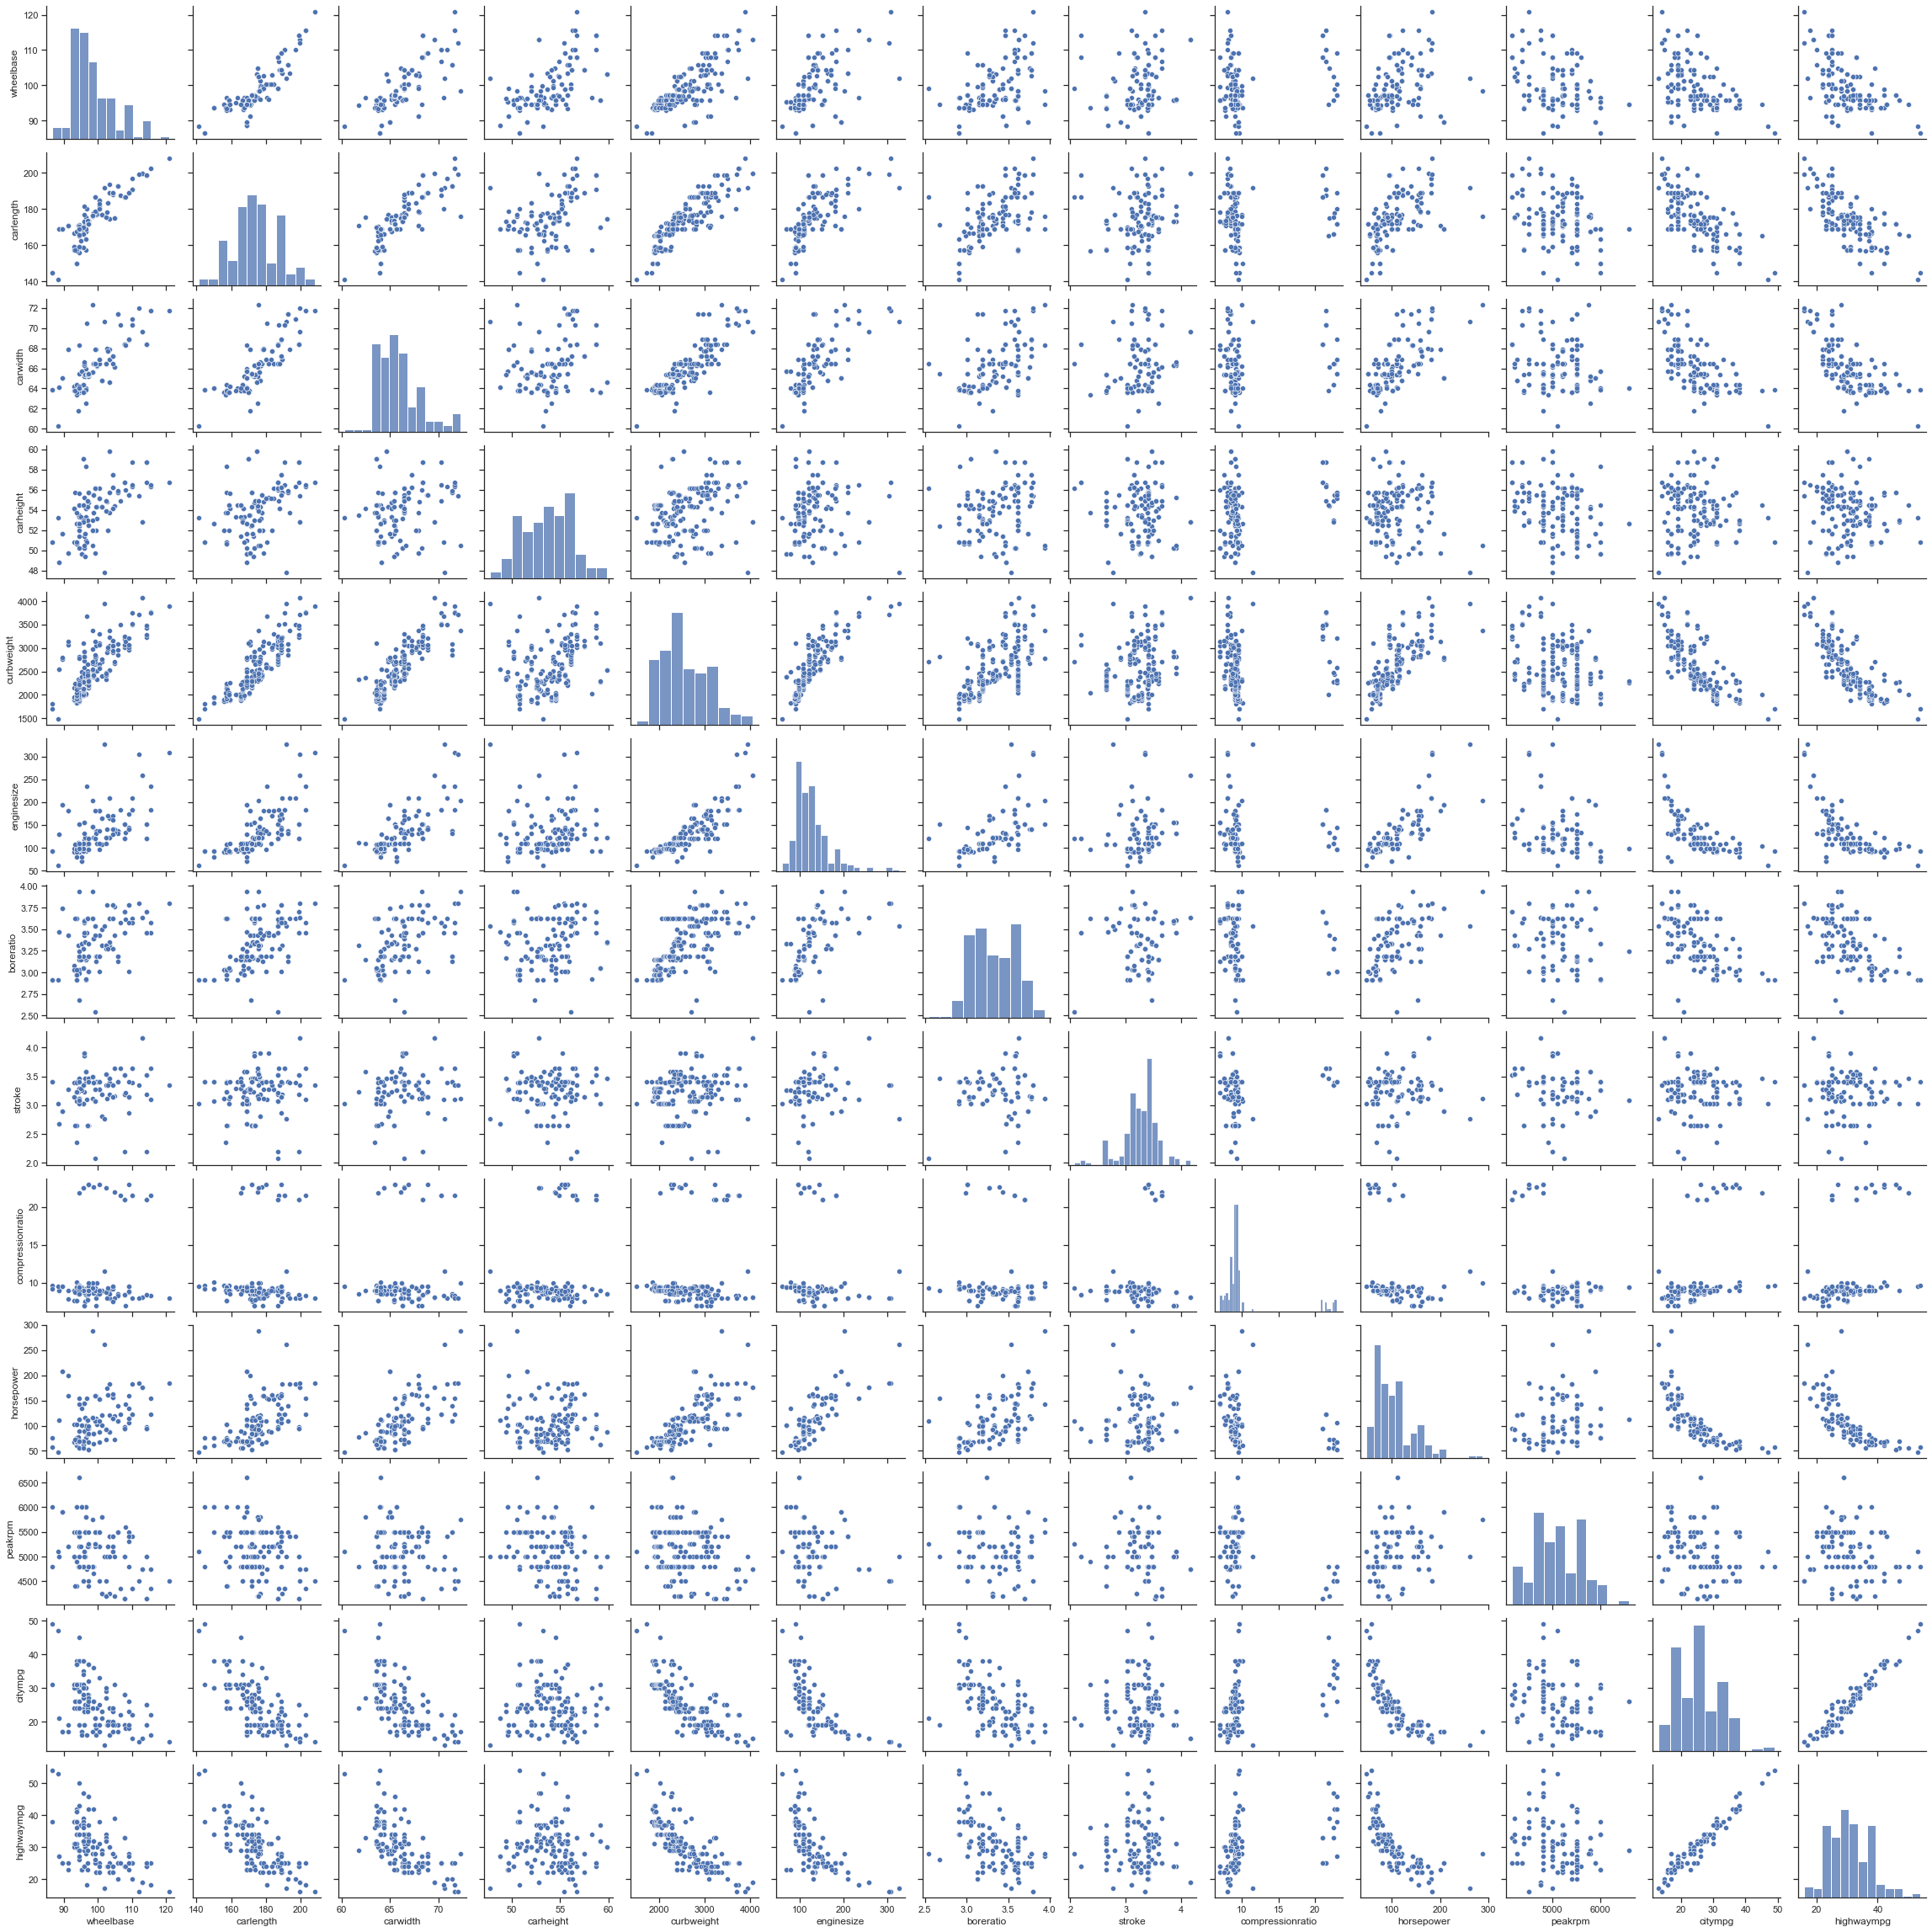

In [50]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

## make a pair plot
columns = numeric_features

axes = sns.pairplot(df,vars=columns,palette="husl")

### Corr plot for linear dependences

<AxesSubplot:>

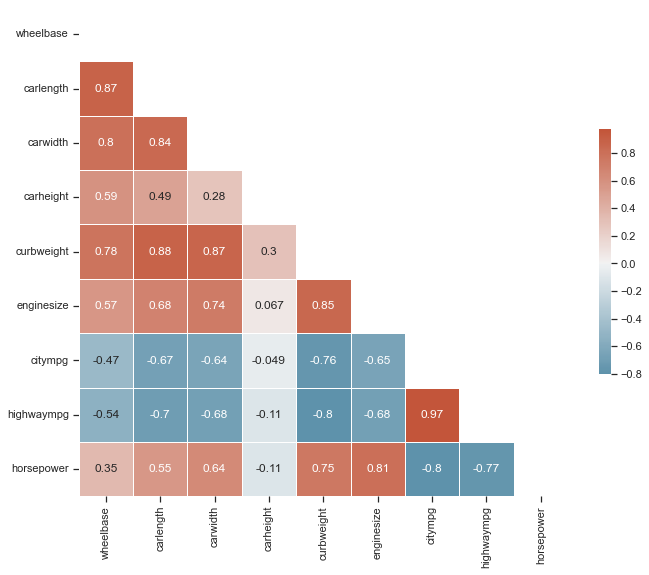

In [51]:
import matplotlib.pyplot as plt
d = df[['wheelbase', 'carlength','carwidth', 'carheight', 'curbweight',
        'enginesize','citympg', 'highwaympg','horsepower']]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

drop correlated features, leave: carheight, horsepower, wheelbase

In [52]:
df.drop(columns=['carlength','carwidth','curbweight','enginesize','citympg', 'highwaympg'],inplace=True)

In [11]:
df[df.compressionratio > 15].fuelsystem.value_counts()

idi    20
Name: fuelsystem, dtype: int64

In [12]:
df[df.fuelsystem == 'idi'].compressionratio.value_counts()

21.0    5
23.0    5
21.5    4
22.5    3
22.7    1
22.0    1
21.9    1
Name: compressionratio, dtype: int64

drop compressionratio - correlates with fuelsystem

In [53]:
df.drop(columns=['compressionratio', 'car_ID'],inplace=True)

In [69]:
categorical_features = ['fueltype', 'aspiration', 'doornumber', 'carbody','cylindernumber','symboling',
                        'drivewheel', 'enginelocation','enginetype','cylindernumber','fuelsystem']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_features = ['wheelbase', 'carheight', 'boreratio', 'stroke', 'horsepower', 'peakrpm']
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

In [55]:
y = df.pop('price')
df.columns

Index(['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carheight',
       'enginetype', 'cylindernumber', 'fuelsystem', 'boreratio', 'stroke',
       'horsepower', 'peakrpm'],
      dtype='object')

In [67]:
df.drop(columns=['CarName'],inplace=True)

In [56]:
df.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carheight,enginetype,cylindernumber,fuelsystem,boreratio,stroke,horsepower,peakrpm
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,48.8,dohc,four,mpfi,3.47,2.68,111,5000
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,48.8,dohc,four,mpfi,3.47,2.68,111,5000
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,52.4,ohcv,six,mpfi,2.68,3.47,154,5000
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,54.3,ohc,four,mpfi,3.19,3.40,102,5500
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,54.3,ohc,five,mpfi,3.19,3.40,115,5500


## Docker command reference

Here is a quick reference to keep your Docker commands accessible.

| command | description |
|:--|:--|
|`docker container ls`| # List all running containers|
|`docker ps` | # List all running containers|
|`docker container ls -a` |  # List all containers, even those not running|
|`docker container stop CONTAINER_ID_OR_NAME` | # Gracefully stop the specified container|
|`docker container kill CONTAINER_ID_OR_NAME` | # Force shutdown of the specified container|
|`docker container rm CONTAINER_ID_OR_NAME`  |   # Remove specified container from this machine|
|`docker container rm $(docker container ls -a -q)` | # Remove all containers|
|`docker image ls -a`  | # List all images on this machine|
|`docker image rm IMAGE_ID_OR_NAME` | # Remove specified image from this machine|
|`docker image rm $(docker image ls -a -q)`   |# Remove all images from this machine|
|`docker login` |# Log in this CLI session using your Docker credentials|

## Persist a machine learning model

Vist the docs to learn more about [model persistence in scikit-learn](https://scikit-learn.org/stable/modules/model_persistence.html).  Be careful with sensitive data and pickle files since the data can easily be extracted.

In [70]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
## train test split check model performance (assumes you have already grid-searched to tune model)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
params_grid = {'reg__n_estimators': [20, 50, 100, 200],
               'reg__max_depth':[2,4,6,8],
               'reg__min_samples_leaf': [2,3,4,5]}   
reg = ensemble.RandomForestRegressor(random_state = 3)
pipe = Pipeline(steps=[('pre', preprocessor),
                       ('reg',reg)])

grid = GridSearchCV(pipe, param_grid = params_grid, cv = 3)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print(mean_squared_error(y_pred,y_test))

## retrain using all of the data
pipe.fit(df, y)
saved_model = 'car_price_prediction.joblib'
joblib.dump(pipe, os.path.join(MODEL_DIR, saved_model))

4779217.243489418


['/Users/mayayozhikova/Downloads/docker-tutorial/models/car_price_prediction.joblib']

In [71]:
grid.best_score_

0.8337016987419311

## Create a simple flask app

In [29]:
%%writefile app.py

from flask import Flask, jsonify, request
import joblib
import socket
import json
import pandas as pd
import os

MODEL_DIR = "/Users/mayayozhikova/Downloads/docker-tutorial/models"
DATA_DIR = "/Users/mayayozhikova/Downloads/docker-tutorial/data"

app = Flask(__name__)

@app.route("/")
def hello():
    html = "<h3>Hello {name}!</h3>" \
           "<b>Hostname:</b> {hostname}<br/>"
    return html.format(name=os.getenv("NAME", "world"), hostname=socket.gethostname())

@app.route('/predict', methods=['GET','POST'])
def predict():
    
    ## input checking
    if not request.json:
        print("ERROR: API (predict): did not receive request data")
        return jsonify([])

    query = request.json
    query = pd.DataFrame(query)
    
    if len(query.shape) == 1:
         query = query.reshape(1, -1)

    y_pred = model.predict(query)
    
    return(jsonify(y_pred.tolist()))        
            
if __name__ == '__main__':
    saved_model = "car_price_prediction.joblib"
    model = joblib.load(os.path.join(MODEL_DIR, saved_model))
    app.run(host='0.0.0.0', port=8080,debug=True)

Overwriting app.py


## Test the flask app

Move into your `docker-tutorial` directory and start the app 


```bash
$ python app.py
```

Then go to [http://0.0.0.0:8080/](http://0.0.0.0:8080/)

Stop the server.  We will relaunch it in a few moments from within Docker.

## Create the DockerFile

Before we build the DockerFile first we need to create a requirement.txt

In [10]:
%%writefile requirements.txt

cython
numpy
flask
pandas
scikit-learn

Writing requirements.txt


In [15]:
%%writefile Dockerfile

# Use an official Python runtime as a parent image
FROM python:3.7.5-stretch

RUN apt-get update && apt-get install -y \
python3-dev \
build-essential    
        
# Set the working directory to /app
WORKDIR /app

# Copy the current directory contents into the container at /app
ADD . /app

# Install any needed packages specified in requirements.txt
RUN pip install --upgrade pip
#RUN pip freeze > requirements.txt
RUN pip install --no-cache-dir -r requirements.txt

# Make port 80 available to the world outside this container
EXPOSE 80

# Define environment variable
ENV NAME World

# Run app.py when the container launches
CMD ["python", "app.py"]

Overwriting Dockerfile


## Build the Docker image and run it

Step one: build the image (from the directory that was created with this notebook)
 
```bash
    ~$ cd docker-tutorial
    ~$ docker build -t example-ml-app .
```

Check that the image is there.

```bash
    ~$ docker image ls
```

Run the container

```bash
docker run -p 4000:8080 example-ml-app
```

## Test the running app

First go to [http://0.0.0.0:4000/](http://0.0.0.0:4000/) 

In [22]:
## create some new data

X_new_data = {}
X_new_data['country'] = ['united_states','united_states','singapore','united_states','singapore']
X_new_data['age'] = [28,30,33,24,39]
X_new_data['subscriber_type'] = ['aavail_premium','aavail_basic','aavail_basic','aavail_basic','aavail_unlimited']
X_new_data['num_streams'] = [9,19,14,33,20]


X_new = pd.DataFrame(X_new_data)
X_new.head()

,country,age,subscriber_type,num_streams
0,united_states,28,aavail_premium,9
1,united_states,30,aavail_basic,19
2,singapore,33,aavail_basic,14
3,united_states,24,aavail_basic,33
4,singapore,39,aavail_unlimited,20


In [72]:
X_new = df.loc[1,:]

In [79]:
X_new = dict(X_new)
X_new['symboling'] = 2
X_new['fueltype'] = 'diesel'
X_new['wheelbase'] = 70
X_new['carheight'] = 50
X_new['cylindernumber'] = 'six'
X_new['horsepower'] = 200
X_new = pd.DataFrame(X_new, index = [0])
X_new.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carheight,enginetype,cylindernumber,fuelsystem,boreratio,stroke,horsepower,peakrpm
0,2,diesel,std,two,convertible,rwd,front,70,50,dohc,six,mpfi,3.47,2.68,200,5000


In [84]:
import requests
from ast import literal_eval


## data needs to be in dict format for JSON
query = X_new.to_dict()

## test the Flask API
# port = 8080
# r = requests.post('http://0.0.0.0:{}/predict'.format(port),json=query)

## test the Docker API
port = 4000
r = requests.post('http://0.0.0.0:{}/predict'.format(port),json=query)

response = literal_eval(r.text)
print(response)

[33336.415]
